### Summary:
* [Problem definition](#problem_definition)
* [Data Analysis](#data_analysis)
* [Market Basket Analysis](#market_basket_analysis)
    * [Item Recommendation](#item_recommendation)
* [Conclusions](#conclusions)
* [References](#references)

In [1]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import unidecode
import plotly.express as px

<a id='problem_definition'></a>
### Problem Defination:

This dataset consisted of 33k orders from two Indian takeaway restaurants in London, UK. The purpose of this notebook is to increase cross-selling when the customer performs by applying makert basket analysis (association rules) where the food could be or recommend when the takeaway is performed:

* Both X and Y could be placed on the same shelf, so that buyers of one item would be prompted to buy the other;
* Promotional discounts could be applied to only one of the two items;
* Advertisements on X could be targeted to shoppers buying Y;
* X and Y could be combined into a new product.

<a id='data_analysis'></a>
### Data Analysis:

Since we have two data sets, we need to merge the information into one for easier analysis. To differentiate it between restaurant orders, first and second, a specific column was created for this purpose and remove the total_products column because it is a sum of the quantity of items in each order.

In [2]:
orders_first_restaurant = pd.read_csv('/kaggle/input/19560-indian-takeaway-orders/restaurant-1-orders.csv')
orders_first_restaurant['restaurant'] = '1 - restaurant'

orders_second_restaurant = pd.read_csv('/kaggle/input/19560-indian-takeaway-orders/restaurant-2-orders.csv')
orders_second_restaurant['restaurant'] = '2 - restaurant'
orders_second_restaurant.rename(columns={'Order ID':'Order Number'},inplace=True)

orders = pd.concat([orders_first_restaurant,orders_second_restaurant])
orders.drop('Total products',axis=1,inplace=True)

To facilitate the analysis, we formatted the columns in lowercase and without spaces.

In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194001 entries, 0 to 119182
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Order Number   194001 non-null  int64  
 1   Order Date     194001 non-null  object 
 2   Item Name      194001 non-null  object 
 3   Quantity       194001 non-null  int64  
 4   Product Price  194001 non-null  float64
 5   restaurant     194001 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 10.4+ MB


In [4]:
orders.sample(5)

,Order Number,Order Date,Item Name,Quantity,Product Price,restaurant
37060,14591,12/02/2018 18:14,Keema Naan,1,2.95,2 - restaurant
25299,5828,28/09/2016 20:34,Naan,1,2.50,2 - restaurant
8316,7989,31/12/2017 13:34,Spicy Papadum,2,0.80,1 - restaurant
38936,12869,17/11/2017 16:59,Pilau Rice,1,2.95,2 - restaurant
2540,21483,22/01/2019 18:25,Mint Sauce,1,0.50,2 - restaurant


In [5]:
def format_columns(column):
    new_column = ' '.join(column.split())
    new_column = new_column.replace(' ','_')
    return new_column.lower()

orders.columns = [format_columns(c) for c in orders.columns]

How we can see, there is no null values in orders

In [6]:
orders.isna().mean()

order_number     0.0
order_date       0.0
item_name        0.0
quantity         0.0
product_price    0.0
restaurant       0.0
dtype: float64

In [7]:
def stats_summary(data):
    
    sales = data['product_price'].sum()
    quantity = data['quantity'].sum()
    orders_count = len(data['order_number'].unique())
    
    avg_price_order = sales / orders_count
    avg_price_food = sales / quantity
    count_food_orders = quantity / orders_count
    
    return {'avg_price_order': avg_price_order,
            'avg_price_food': avg_price_food,
            'count_food_orders': count_food_orders
           }

def print_summary(data):
    
    stats = stats_summary(data)
    
    for key, value in stats.items():
        print(f'{key}: {value:.3}')

As we can see, the difference of the average order price between two restaurants is \\$ 1.44 and the food price of restaurant 1 is 0.16 cents more than the second restaurant, but the quantity of the food per order is higher in the second restaurant, which increases the average order price. The total shows that the average price is \\$ 43.6 and 10 food per order with \\$ 4.15 per food the average.

In [8]:
print('\n1 - restaurant\n')
print_summary(orders[orders['restaurant']=='1 - restaurant'])
print('\n2 - restaurant\n')
print_summary(orders[orders['restaurant']=='2 - restaurant'])

print('\nTotal\n')
print_summary(orders)


1 - restaurant

avg_price_order: 29.5
avg_price_food: 4.25
count_food_orders: 6.94

2 - restaurant

avg_price_order: 31.0
avg_price_food: 4.09
count_food_orders: 7.57

Total

avg_price_order: 43.6
avg_price_food: 4.15
count_food_orders: 10.5


As we can see, the average frequency item is 509, that is, an item appears on average 509 times. When, we look at the median, we see that it is the outliers that pull the average up. The maximum value is 13093, which represents 56.8% of the orders with this item which is Pilau Rice. The frequency percentage of the item is 2.22% (mean / total unit orders) and the median percentage is 0.49%.

In [9]:
items_frequence = orders.groupby('item_name').size().reset_index(name='quantity')
print(items_frequence.describe())
print(f'\ntotal unique orders: {len(orders["order_number"].unique())}')

           quantity
count    381.000000
mean     509.188976
std     1261.237290
min        1.000000
25%       26.000000
50%      113.000000
75%      408.000000
max    13093.000000

total unique orders: 23041


We need to remove the extra spaces, symbols or accents if any, because maybe there are duplicate items but the same text with another way of writing.

In [10]:
def text_normalization(text):
    new_text = ' '.join(text.split())
    return unidecode.unidecode(new_text.lower())

orders['item_name'] = orders['item_name'].apply(text_normalization)

<a id='market_basket_analysis'></a>
### Market Basket Analysis (Association Rules)

Through the frequency of the items in the orders, we try to understand if there is an association between one product and another in the order with the objective of recommending this product in an extra purchase.

### Example
We have a Market Basket transactions, where diapers and beer are a set of frequent items and with that, we have those who buy diapers have a probability of buying beer.

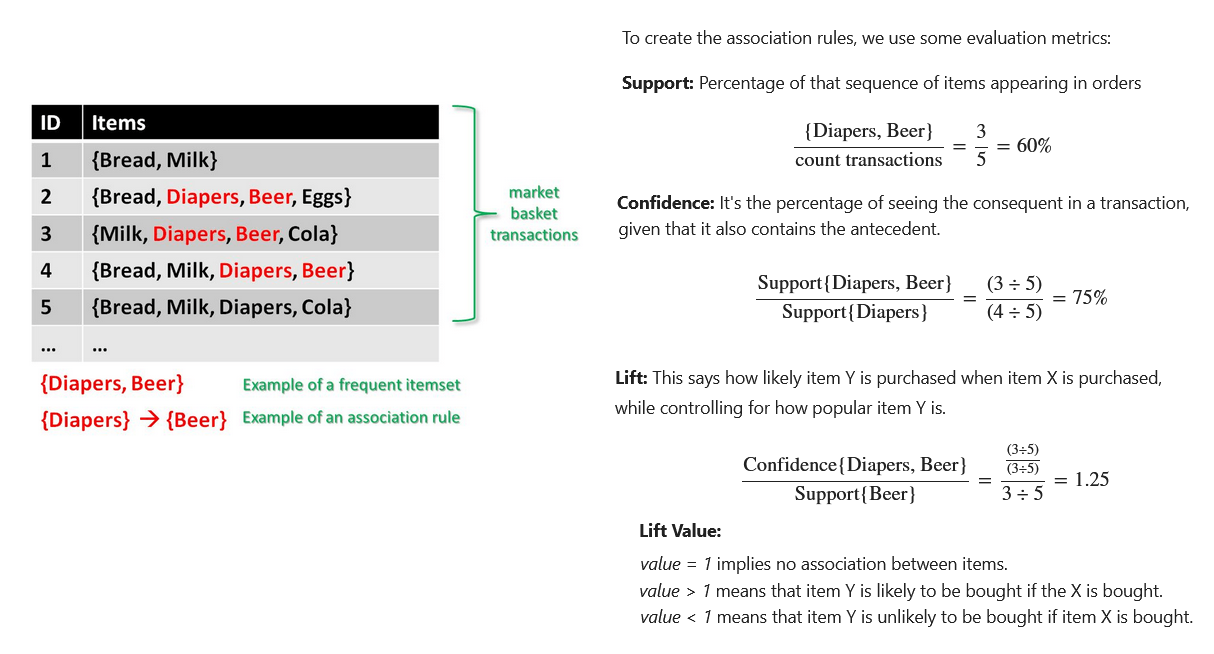

We need to transform the dataset into a list of items in order and convert it into a matrix (data set) where the columns are items and the rows are the order. If that item belongs to that order the value 1 is assigned, otherwise 0.

In [11]:
#convert the dataframe to list items in order
item_list = orders.groupby('order_number')['item_name'].unique()

# transform the values of the data set to 1 if that item belongs to that order, otherwise 0
te = TransactionEncoder()
oht_orders = te.fit(item_list).transform(item_list, sparse=True)

To save memory, we represent the transaction data in sparse format.  Because, we have 316 items and 23041 orders.

In [12]:
sparse_df_items = pd.DataFrame.sparse.from_spmatrix(oht_orders, columns=te.columns_)

As a threshold for the minimum frequency of a set of items(the support metric), we used the percentage of the average/unique order frequency, which is 2.22% and max len of set of items equals 10. 

In [13]:
frequent_itemsets = apriori(sparse_df_items, min_support=0.02209,max_len=11, use_colnames=True, verbose=1)

Processing 600 combinations | Sampling itemset size 54


We create a copy of frequent item sets to create a custom output and analyze.

In [14]:
frequent_itemsets_plot = frequent_itemsets.copy()
frequent_itemsets_plot['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets_plot['support'] = (frequent_itemsets_plot['support'] * 100).round(2)
frequent_itemsets_plot["itemsets"] = frequent_itemsets_plot["itemsets"].apply(lambda x: ', '.join(list(x))).astype("str")

We get 556 frequency item sets with the filter we apply. We can see, that most of the item set sizes are 2 and the maximum value is 5. But it is not necessary that this itemset has a high frequency in orders. We have a high std for length equal to 1 indicating item variability and a low variability for length equal to 2 or 3 representing 4.64% and 3.48% respectively on average in the orders.

In [15]:
frequent_itemsets_plot.groupby('length')['support'].describe()

,count,mean,std,min,25%,50%,75%,max
length,,,,,,,,
1,73.0,8.864384,8.976832,2.22,3.2800,5.06,10.580,50.17
2,252.0,4.637302,3.121391,2.21,2.7375,3.51,5.215,24.15
3,197.0,3.484112,1.451654,2.21,2.5400,2.99,3.920,12.07
4,43.0,2.908140,0.703607,2.27,2.4300,2.68,3.100,5.01
5,1.0,2.280000,NaN,2.28,2.2800,2.28,2.280,2.28


As we can see, 50% of orders have rice pilau and 39.78% have simple papadum and other information is 24.15% of orders have simple papadum and rice pilau in the same order and 19.2% have simple papadum, mango chutney. In addition, 2.28% of orders have simple papadum, onion chutney, mango chutney, mint sauce, rice pilau as items.

In [16]:
top_20_frequence = frequent_itemsets_plot.sort_values('support',ascending=False).head(20).sort_values('support')
fig = px.bar(top_20_frequence, x="support", y="itemsets", orientation='h', text='support')
fig.update_traces(textposition="outside")
fig.show()

We filter an lift equal to 1 to get only rules that have a probability of buying the antecedents and consequents in the same order. As we can see, we have a high probability of recomedations if the customer buys an item. For example, we have 174 possibilities of recommendations if the customer buys a plain papadum.

In [17]:
market_basket_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
market_basket_rules.groupby('antecedents').size().sort_values(ascending=False)

antecedents
(plain papadum)                                           174
(pilau rice)                                              166
(mango chutney)                                           105
(naan)                                                     71
(mint sauce)                                               70
                                                         ... 
(naan, garlic naan, pilau rice)                             1
(mint sauce, garlic naan, pilau rice)                       1
(mango chutney, garlic naan, pilau rice)                    1
(mango chutney, mint sauce, garlic naan)                    1
(mint sauce, mango chutney, plain papadum, pilau rice)      1
Length: 285, dtype: int64

<a id='item_recommendation'></a>
### Item Recommendation

To filter the best recommendations we will use the highest confidence value for each antecedent. We ran with the top 20 most frequent items and got some recommendations:

* 4.44% (confidence) of those who buys pilau rice, buys paratha as well;
* If one buys garlic naan, it's likely that one has also bought plain papadum with saag aloo. This way, it is possible to create a bundle with these items and apply a discount;
* If one buys pilau rice with chicken tikka masala it's likely that one has also bought madras. This way, it is possible apply discount in the madras.

In [18]:
best_item_recommendations = market_basket_rules.sort_values(['confidence','lift'],ascending='False').drop_duplicates(subset=['antecedents'])
top_20_frequence_items = frequent_itemsets.sort_values('support',ascending=False).head(20)['itemsets']
best_item_recommendations[best_item_recommendations['antecedents'].isin(top_20_frequence_items)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
407,(pilau rice),(paratha),0.501714,0.041014,0.022091,0.044031,1.073568,0.001514,1.003156
1013,(plain papadum),"(saag aloo, garlic naan)",0.397813,0.044529,0.022091,0.055531,1.247073,0.004377,1.011649
159,(naan),(french fries),0.289875,0.058982,0.022134,0.076359,1.294615,0.005037,1.018813
1012,(garlic naan),"(saag aloo, plain papadum)",0.266655,0.062844,0.022091,0.082845,1.318255,0.005333,1.021807
1827,"(plain papadum, pilau rice)","(naan, garlic naan)",0.241526,0.060197,0.022742,0.094160,1.564195,0.008203,1.037493
457,(bombay aloo),"(chicken tikka masala, garlic naan)",0.243522,0.074606,0.023263,0.095527,1.280413,0.005095,1.023130
695,(chicken tikka masala),"(mushroom rice, garlic naan)",0.231197,0.062150,0.022265,0.096302,1.549505,0.007896,1.037791
94,(mango chutney),(chicken tikka (main)),0.227811,0.090144,0.022308,0.097923,1.086304,0.001772,1.008624
1093,(plain rice),"(korma, pilau rice)",0.213012,0.080075,0.022351,0.104931,1.310411,0.005295,1.027770
2202,"(mango chutney, plain papadum)","(onion chutney, mint sauce, pilau rice)",0.192006,0.034808,0.022785,0.118671,3.409346,0.016102,1.095156


<a id='conclusions'></a>
### Conclusions:

* The quantity of the food per order is higher in the second restaurant, which increases the average order price with difference \\$ 1.44;
* The average price is \\$ 43.6 and 10 food per order with \\$ 4.15 per food the average;
* The average frequency item is 509, that is, an item appears on average 509 times which represets 2.22%;
* 50,17% of orders has pilau rice;
* 24.15% of orders have simple papadum and rice pilau in the same order 19.2% have simple papadum, mango chutney;
* 2.28% of orders have simple papadum, onion chutney, mango chutney, mint sauce, rice pilau as items;
* 4.44% (confidence) of those who buys pilau rice, buys paratha as well;
* If one buys plain papadum with pilau rice it's likely that one has also bought garlic naan with naan;
* If one buys garlic naan, it's likely that one has also bought plain papadum with saag aloo. This way, it is possible to create a bundle with these items and apply a discount;
* If one buys pilau rice with chicken tikka masala it's likely that one has also bought madras. This way, it is possible apply discount in the madras.


And that’s it! It has been a pleasure to make this kernel, I have learned a lot! Thank you for reading and if you like it, please upvote it!

<a id='references'></a>
### References:

Annalyn Ng(2016) Association rules apriori algorithm tutorial. Retrieved from: [https://www.kdnuggets.com/2016/04/association-rules-apriori-algorithm-tutorial.html](https://www.kdnuggets.com/2016/04/association-rules-apriori-algorithm-tutorial.html)

Hafsa Jabeen(2018) Market Basket Analysis using R. Retrieved from: [https://www.datacamp.com/community/tutorials/market-basket-analysis-r](https://www.datacamp.com/community/tutorials/market-basket-analysis-r)

Association Rules. Retrived from: [http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/)

Apriori. Retrived from: [http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
